In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, log_loss, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, average_precision_score, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

### Now we will try to solve the problem using Non-Linear models such as non-linear SVM

#### Loading Pre-processed Dataset & Training/Eval function

In [15]:
# Load dataset from CSV
csv_file = 'Dataset/cleaned.csv'
df = pd.read_csv(csv_file)

# Separate features and target
y = df['anomaly'].values
X = df.drop(columns=['anomaly']).values

# Save meter_reading column separately
meter_reading = df['meter_reading'].values

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [16]:
# Train/Test split with stratification
X_train, X_test, y_train, y_test, meter_train, meter_test = train_test_split(
    X, y, meter_reading, train_size=0.05, test_size=0.01, random_state=42, stratify=y)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

1865 85609
373 17122
(87474, 29) (87474,)
(17495, 29) (17495,)


In [14]:
model = SVC(kernel='rbf', probability=True, verbose= True, class_weight='balanced')

In [17]:
def trainAndEvaluate(show= False):

    model.fit(X_train, y_train)
    
    # Evaluate on test set
    test_pred = model.predict(X_test)
    test_pred_proba = model.predict_proba(X_test)[:, 1]

    # Set prediction to 0 where meter_reading is missing
    test_pred = np.where(meter_test == -1, 0, test_pred)

    # Metrics on test set
    test_acc = accuracy_score(y_test, test_pred)
    test_f1 = f1_score(y_test, test_pred, zero_division=0)
    test_auc = roc_auc_score(y_test, test_pred_proba)
    test_precision = precision_score(y_test, test_pred, zero_division=0)
    test_recall = recall_score(y_test, test_pred, zero_division=0)
    test_auprc = average_precision_score(y_test, test_pred_proba)
    
    if show:
        print(f"Test - Acc: {test_acc}, F1: {test_f1}, AUC: {test_auc}, AUC-PR: {test_auprc}, Precision: {test_precision}, Recall: {test_recall}")

        # Confusion matrix
        cm = confusion_matrix(y_test, test_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
        plt.title("Confusion Matrix on Test Set")
        plt.show()

        # Calculate zeroR baseline metrics
        zeroR = np.bincount(y_test).argmax()
        y_pred_zeroR = np.full_like(y_test, zeroR)
        zeroR_acc = accuracy_score(y_test, y_pred_zeroR)
        zeroR_f1 = f1_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_precision = precision_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_recall = recall_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_auc = roc_auc_score(y_test, y_pred_zeroR)
        zeroR_auprc = average_precision_score(y_test, y_pred_zeroR)

        print(f"ZeroR Baseline Metrics:")
        print(f"  Accuracy: {zeroR_acc}")
        print(f"  F1 Score: {zeroR_f1}")
        print(f"  Precision: {zeroR_precision}")
        print(f"  Recall: {zeroR_recall}")
        print(f"  AUC: {zeroR_auc}")
        print(f"  AUC-PR: {zeroR_auprc}")

[LibSVM]Test - Acc: 0.8953415261503287, F1: 0.2185232607767819, AUC: 0.8477529027609151, AUC-PR: 0.22145262999388118, Precision: 0.1299492385786802, Recall: 0.6863270777479893


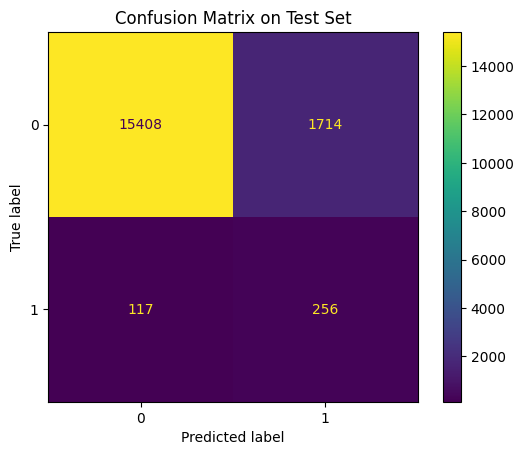

ZeroR Baseline Metrics:
  Accuracy: 0.9786796227493569
  F1 Score: 0.0
  Precision: 0.0
  Recall: 0.0
  AUC: 0.5
  AUC-PR: 0.021320377250643043


In [18]:
trainAndEvaluate(show=True)

Non-linear SVM take a lot of time to fit on large data, so we need to transform our data into linear one or train on GPU.

In [ ]:
#TODO: transform data to linear or use GPU in training

### We have the problem of the heavily imbalanced dataset which we will try to solve by:
1) Using a subset of the dataset with an equal distribution for both target classes
2) Over-sampling the dataset by generating samples from the minor class

In [22]:
# Create a balanced sample from the dataset
class_0 = df[df['anomaly'] == 0]
class_1 = df[df['anomaly'] == 1]

# Sample equal number from each class (based on minority class size)
min_len = min(len(class_0), len(class_1))
df_balanced = pd.concat([
    class_0.sample(min_len, random_state=42),
    class_1.sample(min_len, random_state=42)
], ignore_index=True).sample(frac=1, random_state=42)  # Shuffle

print(df_balanced['anomaly'].value_counts())

anomaly
1    37296
0    37296
Name: count, dtype: int64


In [23]:
# Separate features and target
y = df_balanced['anomaly'].values
X = df_balanced.drop(columns=['anomaly']).values

# Save meter_reading column separately
meter_reading = df_balanced['meter_reading'].values

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/Val/Test split with stratification
X_train, X_test, y_train, y_test, meter_train, meter_test = train_test_split(
    X, y, meter_reading, test_size=0.1, random_state=42, stratify=y)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

33566 33566
3730 3730
(67132, 29) (67132,)
(7460, 29) (7460,)


In [ ]:
model = SVC(kernel='rbf', probability=True, verbose= True)
trainAndEvaluate(show=True)

[LibSVM]